In [ ]:
# default_exp interpret

In [ ]:
#export
from local.test import *
from local.data.all import *
from local.optimizer import *
from local.learner import *

# Interpretation

> Classes to build objects to better interpret predictions of a model

In [ ]:
#export
@typedispatch
def plot_top_losses(x: TensorImage, y:TensorCategory, its, raws, losses, rows=None, cols=None, figsize=None, **kwargs):
    axs = get_grid(len(its), rows=rows, cols=cols, add_vert=1, figsize=figsize, title='Prediction/Actual/Loss/Probability')
    for ax,it,r,l in zip(axs, its, raws, losses):
        it[0].show(ctx=ax, **kwargs)
        ax.set_title(f'{it[2]}/{it[1]} / {l.item():.2f} / {r.max().item():.2f}')

In [ ]:
class Interpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, dl, inputs, preds, decoded, targs, losses):
        store_attr(self, "dl,inputs,preds,decoded,targs,losses")

    @classmethod
    def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretatio object from a learner"
        if dl is None: dl = learn.dbunch.dls[ds_idx]
        return cls(dl, *learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None))

    def top_losses(self, k=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        return self.losses.topk(ifnone(k, len(self.losses)), largest=largest)
    
    def plot_top_losses(self, k, largest=True, **kwargs):
        losses,idx = self.top_losses(k, largest)
        b = tuple(o[idx] for o in self.inputs + (self.targs if isinstance(self.targs, tuple) else (self.targs,)))
        x,y,its = self.dl._pre_show_batch(b, max_n=k)
        b_out = tuple(o[idx] for o in self.inputs + (tuple(self.decoded) if is_listy(self.decoded) else (self.decoded,)))
        x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            its = L(i + o[len(self.inputs):] for i,o in zip(its,outs))
            plot_top_losses(x, y, its, self.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knos how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

In [ ]:
from local.vision.all import *
from local.metrics import *

In [ ]:
pets = DataBlock(types=(PILImage, Category), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'))

In [ ]:
dbunch = pets.databunch(untar_data(URLs.PETS)/"images", item_tfms=RandomResizedCrop(300, min_scale=0.5), bs=64,
                        batch_tfms=[*aug_transforms(size=224), Normalize(*imagenet_stats)])

In [ ]:
from torchvision.models import resnet34

In [ ]:
opt_func = partial(Adam, lr=3e-3, wd=0.01)

In [ ]:
learn = cnn_learner(dbunch, resnet34, opt_func=opt_func, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.939297,0.333597,0.114344,00:19


In [ ]:
interp = Interpretation.from_learner(learn)

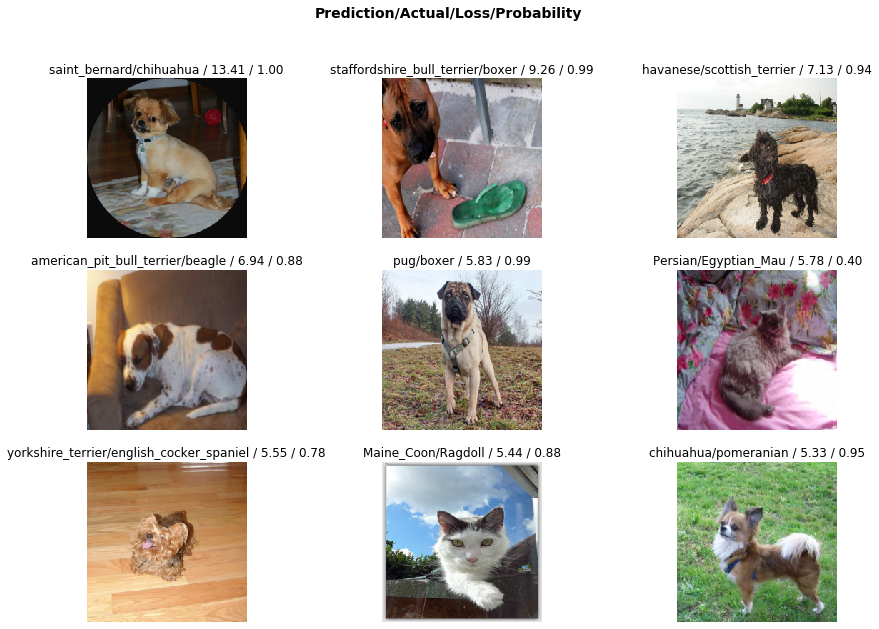

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))